# Adaptive RAG

적응형 RAG는 (1) 쿼리 분석과 (2) 능동적/자기 교정적 RAG를 결합한 RAG 전략입니다.

논문에서는 쿼리 분석을 통해 다음과 같이 라우팅한다고 보고합니다:

1. 검색 없음
2. 단일 샷 RAG
3. 반복적 RAG

LangGraph를 사용하여 이를 기반으로 구축해 보겠습니다.

우리의 구현에서는 다음 사이를 라우팅할 것입니다:

1. 웹 검색: 최근 사건과 관련된 질문에 대해
2. 자기 교정적 RAG: 우리의 인덱스와 관련된 질문에 대해

이 접근 방식은 질문의 특성에 따라 적절한 정보 검색 방법을 선택하여 더 효과적인 답변을 생성하는 것을 목표로 합니다.

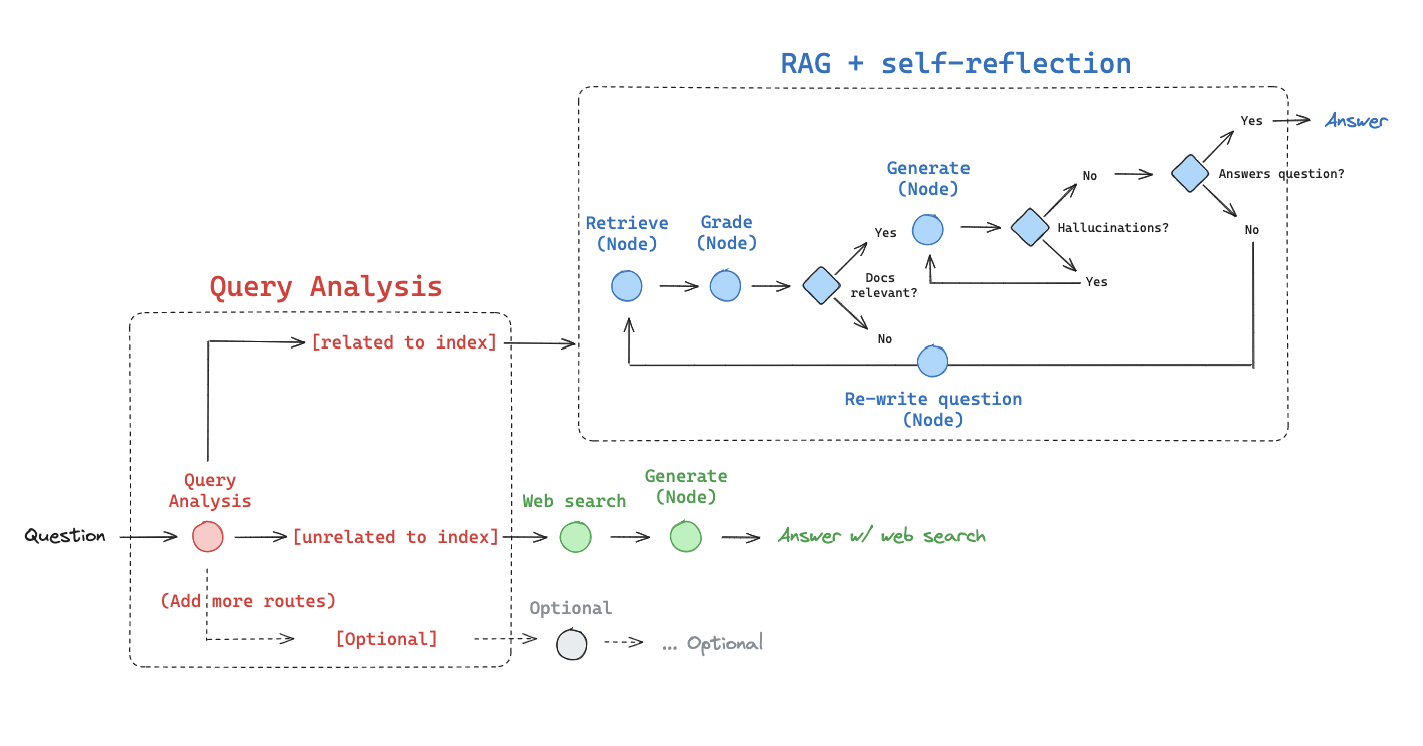

## Setup

먼저, 필요한 패키지를 설치하고 API 키를 설정하겠습니다.

In [ ]:
%%capture --no-stderr
! pip install -U langchain_community tiktoken langchain-openai langchain-cohere langchainhub chromadb langchain langgraph  tavily-python

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("COHERE_API_KEY")
_set_env("TAVILY_API_KEY")

## 인덱스 구축


In [40]:
# 필요한 라이브러리 및 모듈 임포트
from langchain.text_splitter import RecursiveCharacterTextSplitter  # 문서를 작은 청크로 분할하기 위한 도구
from langchain_community.document_loaders import WebBaseLoader  # 웹 페이지에서 문서를 로드하기 위한 도구
from langchain_community.vectorstores import Chroma  # 벡터 데이터베이스를 위한 Chroma
from langchain_openai import OpenAIEmbeddings  # OpenAI의 임베딩 모델

### from langchain_cohere import CohereEmbeddings  # Cohere의 임베딩 모델 (현재 주석 처리됨)

# OpenAI의 임베딩 모델 초기화
# 이 모델은 텍스트를 벡터로 변환하는 데 사용됩니다.
embd = OpenAIEmbeddings()

# 인덱싱할 문서의 URL 리스트
# 이 URL들은 AI 에이전트, 프롬프트 엔지니어링, LLM에 대한 적대적 공격에 관한 블로그 포스트입니다.
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# 각 URL에서 문서 로드
# WebBaseLoader를 사용하여 각 URL의 내용을 로드하고, 결과를 리스트로 저장합니다.
docs = [WebBaseLoader(url).load() for url in urls]

# 로드된 문서를 단일 리스트로 평탄화
# 각 URL에서 로드된 문서들을 하나의 리스트로 합칩니다.
docs_list = [item for sublist in docs for item in sublist]

# 문서 분할 설정
# RecursiveCharacterTextSplitter를 사용하여 긴 문서를 작은 청크로 나눕니다.
# tiktoken 인코더를 사용하여 토큰 기반으로 분할합니다.
# chunk_size: 각 청크의 최대 토큰 수
# chunk_overlap: 연속된 청크 간의 중복되는 토큰 수 (여기서는 0으로 설정되어 중복 없음)
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)

# 문서를 청크로 분할
doc_splits = text_splitter.split_documents(docs_list)

# Chroma 벡터 저장소 생성 및 문서 추가
# 분할된 문서를 벡터화하고 Chroma 데이터베이스에 저장합니다.
vectorstore = Chroma.from_documents(
    documents=doc_splits,  # 분할된 문서 청크
    collection_name="rag-chroma",  # Chroma 컬렉션 이름
    embedding=embd,  # 사용할 임베딩 모델
)

# 벡터 저장소를 검색 가능한 형태로 변환
# 이를 통해 나중에 유사한 문서를 검색할 수 있습니다.
retriever = vectorstore.as_retriever()


## LLMs
### 라우터

In [42]:
# 필요한 라이브러리와 모듈을 임포트합니다.
from typing import Literal  # Literal 타입을 사용하기 위해 임포트
from langchain_core.prompts import ChatPromptTemplate  # 채팅 프롬프트 템플릿을 위한 임포트
from langchain_openai import ChatOpenAI  # OpenAI의 채팅 모델을 사용하기 위한 임포트
# Pydantic을 사용하여 데이터 모델을 정의하기 위한 임포트
# 주의: langchain-core 버전 0.3 이상과 Pydantic v2를 함께 사용해야 합니다.
from pydantic import BaseModel, Field

# 사용자 쿼리를 라우팅하기 위한 데이터 모델을 정의합니다.
class RouteQuery(BaseModel):
    """사용자 쿼리를 가장 관련성 높은 데이터 소스로 라우팅합니다."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,  # 이 필드는 반드시 값이 제공되어야 함을 나타냅니다.
        description="주어진 사용자 질문을 웹 검색 또는 벡터 저장소로 라우팅하도록 선택합니다.",
    )

# OpenAI의 GPT-4o 모델을 사용하여 LLM(Large Language Model)을 설정합니다.
# temperature=0으로 설정하여 가장 확실한 응답을 얻습니다.
llm = ChatOpenAI(model="gpt-4o", temperature=0)
# LLM에 구조화된 출력 기능을 추가합니다. 이를 통해 모델이 RouteQuery 형식으로 응답합니다.
structured_llm_router = llm.with_structured_output(RouteQuery)

# 라우팅을 위한 시스템 프롬프트를 정의합니다.
system = """당신은 사용자 질문을 벡터 저장소 또는 웹 검색으로 라우팅하는 전문가입니다.
벡터 저장소에는 에이전트, 프롬프트 엔지니어링 및 적대적 공격과 관련된 문서가 포함되어 있습니다.
이러한 주제에 대한 질문에는 벡터 저장소를 사용하세요. 그 외의 경우에는 웹 검색을 사용하세요."""

# 채팅 프롬프트 템플릿을 생성합니다.
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),  # 시스템 메시지로 위에서 정의한 프롬프트를 사용
        ("human", "{question}"),  # 사용자 질문을 위한 플레이스홀더
    ]
)

# 프롬프트와 구조화된 LLM을 연결하여 질문 라우터를 생성합니다.
question_router = route_prompt | structured_llm_router

# 테스트 질문을 사용하여 라우터를 실행하고 결과를 출력합니다.
print( question_router.invoke({"question": "베어스가 NFL 드래프트에서 첫 번째로 누구를 선발할 것인가?"}))
print(question_router.invoke({"question": "에이전트 메모리의 유형은 무엇인가요?"}))

datasource='web_search'
datasource='vectorstore'


### 검색 결과 평가기

In [45]:
# 데이터 모델 정의
class GradeDocuments(BaseModel):
    """검색된 문서의 관련성 체크를 위한 이진 점수."""

    binary_score: str = Field(
        description="문서가 질문과 관련이 있으면 'yes', 그렇지 않으면 'no'"
    )
    # 이 클래스는 문서의 관련성을 평가하기 위한 구조를 정의합니다.
    # binary_score 필드는 문서가 질문과 관련있는지 여부를 'yes' 또는 'no'로 나타냅니다.

# 함수 호출이 가능한 LLM(Large Language Model) 설정
llm = ChatOpenAI(model="gpt-4o", temperature=0)
# ChatOpenAI 인스턴스를 생성하여 GPT-4o 모델을 사용합니다.
# temperature=0으로 설정하여 가장 결정적인(일관된) 응답을 얻습니다.

structured_llm_grader = llm.with_structured_output(GradeDocuments)
# LLM에 구조화된 출력 기능을 추가합니다.
# 이를 통해 모델이 GradeDocuments 형식으로 응답하도록 합니다.

# 프롬프트 설정
system = """당신은 검색된 문서가 사용자 질문과 관련이 있는지 평가하는 전문가입니다.
평가 기준:
1. 문서에 사용자 질문과 관련된 키워드나 의미가 포함되어 있는지 확인하세요.
2. 엄격한 기준을 적용할 필요는 없습니다. 주요 목적은 명백히 관련 없는 검색 결과를 필터링하는 것입니다.
3. 평가 결과는 'yes' 또는 'no'로만 제공하세요."""
# 이 시스템 프롬프트는 LLM에게 문서 평가 작업에 대한 지침을 제공합니다.
# 관련성 판단 기준, 평가의 엄격성 정도, 그리고 출력 형식을 명시합니다.

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "검색된 문서: \n\n {document} \n\n 사용자 질문: {question}"),
    ]
)
# ChatPromptTemplate을 사용하여 프롬프트 템플릿을 생성합니다.
# 시스템 메시지와 사용자 입력(문서와 질문)을 포함하는 구조화된 프롬프트를 만듭니다.

retrieval_grader = grade_prompt | structured_llm_grader
# 프롬프트 템플릿과 구조화된 LLM을 파이프라인으로 연결합니다.
# 이 파이프라인은 주어진 문서와 질문에 대해 관련성을 평가하고 구조화된 출력을 제공합니다.

In [46]:
# 질문 설정
question = "agent memory"

# 검색기를 사용하여 문서 검색
docs = retriever.invoke(question)

# 두 번째 문서의 내용 추출
doc_txt = docs[1].page_content

# 검색된 문서의 관련성 평가 및 결과 출력
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [49]:
# 새로운 질문 설정
question2 = "손홍민의 올해의 실적은?"
# 손흥민 선수의 올해 실적에 대한 질문을 설정합니다.

# 새 질문으로 문서 검색
docs2 = retriever.invoke(question2)
# retriever를 사용하여 설정한 질문에 대한 관련 문서를 검색합니다.

# 두 번째 검색된 문서의 내용 추출
doc_txt2 = docs2[1].page_content
# 검색된 문서 중 두 번째 문서의 내용을 추출합니다.

print(retrieval_grader.invoke({"question": question2, "document": doc_txt2}))
# retrieval_grader를 사용하여 추출된 문서와 질문의 관련성을 평가하고 결과를 출력합니다.


binary_score='no'


### 생성

In [50]:
# Langchain 라이브러리에서 필요한 모듈들을 가져옵니다.
from langchain import hub  # 사전 정의된 프롬프트를 가져오기 위한 hub 모듈
from langchain_core.output_parsers import StrOutputParser  # 문자열 출력 파서

# 사전 정의된 RAG(Retrieval-Augmented Generation) 프롬프트를 hub에서 가져옵니다.
# 이 프롬프트는 검색된 문서와 질문을 결합하여 응답을 생성하는 데 사용됩니다.
prompt = hub.pull("rlm/rag-prompt")

# LLM(Large Language Model) 설정
# ChatOpenAI 클래스를 사용하여 GPT-4 모델을 초기화합니다.
# temperature=0으로 설정하여 가장 확실한(결정적인) 출력을 얻습니다.
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

# 문서 포맷팅 함수 정의
# 이 함수는 여러 문서의 내용을 하나의 문자열로 결합합니다.
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# RAG 체인 구성
# 프롬프트, LLM, 문자열 출력 파서를 파이프라인으로 연결합니다.
# 이 체인은 주어진 컨텍스트와 질문을 바탕으로 응답을 생성합니다.
rag_chain = prompt | llm | StrOutputParser()

In [51]:
# 질문 설정
question = "agent memory"
# 에이전트 메모리에 대한 질문을 설정합니다.

# 문서 검색
docs = retriever.invoke(question)
# retriever를 사용하여 설정한 질문에 대한 관련 문서를 검색합니다.

# 두 번째 검색된 문서의 내용 추출
doc_txt = docs[1].page_content
# 검색된 문서 중 두 번째 문서의 내용을 추출합니다.

# RAG 체인을 사용하여 응답 생성
generation = rag_chain.invoke({"context": docs, "question": question})
# 검색된 문서와 질문을 입력으로 사용하여 RAG 체인을 통해 응답을 생성합니다.

# 생성된 응답 출력
print(generation)
# 생성된 응답을 콘솔에 출력합니다.

Agent memory in LLM-powered autonomous agents involves a long-term memory module that records the agent's experiences in natural language. This memory stream includes observations and events, which can be triggered by inter-agent communication. The retrieval model then surfaces relevant, recent, and important memories to inform the agent's behavior.


### 환각 평가기

In [53]:
# 데이터 모델 정의
class GradeHallucinations(BaseModel):
    """
    생성된 답변에 환각이 있는지 확인하는 이진 점수를 나타내는 클래스입니다.
    환각은 실제 데이터나 사실에 근거하지 않은 잘못된 정보를 의미합니다.
    """

    binary_score: str = Field(
        description="답변이 사실에 근거하면 'yes', 그렇지 않으면 'no'로 표시됩니다."
    )

# 함수 호출이 가능한 LLM(Large Language Model) 설정
# ChatOpenAI 클래스를 사용하여 GPT-4o 모델을 초기화합니다.
llm = ChatOpenAI(model="gpt-4o", temperature=0)
# LLM에 GradeHallucinations 클래스의 구조화된 출력을 적용합니다.
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# 프롬프트 설정
# 시스템 메시지로 LLM에게 평가자 역할을 부여합니다.
system = """당신은 LLM 생성이 검색된 사실 집합에 근거하거나 지원되는지 평가하는 평가자입니다. \n 
     이진 점수 'yes' 또는 'no'를 제공하세요. 'Yes'는 답변이 사실 집합에 근거하거나 지원된다는 의미입니다."""
# ChatPromptTemplate을 사용하여 대화형 프롬프트를 생성합니다.
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "사실 집합: \n\n {documents} \n\n LLM 생성: {generation}"),
    ]
)

# 환각 평가 파이프라인 구성
# 프롬프트와 구조화된 LLM 평가자를 연결합니다.
hallucination_grader = hallucination_prompt | structured_llm_grader


In [54]:
# 환각 평가 실행
# 질문 설정
question = "agent memory"
# 에이전트 메모리에 대한 질문을 설정합니다.

# 문서 검색
docs = retriever.invoke(question)
# retriever를 사용하여 설정한 질문에 대한 관련 문서를 검색합니다.

# 두 번째 검색된 문서의 내용 추출
doc_txt = docs[1].page_content
# 검색된 문서 중 두 번째 문서의 내용을 추출합니다.

# RAG 체인을 사용하여 응답 생성
generation = rag_chain.invoke({"context": docs, "question": question})

# 검색된 문서와 생성된 텍스트를 입력으로 사용하여 환각 여부를 평가합니다.
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

### 답변 평가기

In [71]:
# 답변 평가를 위한 데이터 모델 정의
class GradeAnswer(BaseModel):
    """질문에 대한 답변 적절성을 평가하는 이진 점수."""

    binary_score: str = Field(
        description="답변이 질문을 해결하는지 여부, 'yes' 또는 'no'"
    )
    # binary_score 필드는 답변의 적절성을 '예' 또는 '아니오'로 나타냅니다.

# LLM(Large Language Model) 설정
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
# ChatOpenAI 모델을 사용하며, temperature=0으로 설정하여 일관된 출력을 얻습니다.

# LLM에 구조화된 출력 적용
structured_llm_grader = llm.with_structured_output(GradeAnswer)
# LLM의 출력을 GradeAnswer 클래스 형식으로 구조화합니다.

# 시스템 프롬프트 설정
system = """당신은 답변이 질문을 해결하거나 다루는지 평가하는 채점자입니다. \n 
     '예' 또는 '아니오'로 이진 점수를 제공하세요. '예'는 답변이 질문을 해결한다는 의미입니다."""
# 이 프롬프트는 LLM에게 답변 평가자 역할을 부여합니다.

# 채팅 프롬프트 템플릿 생성
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "사용자 질문: \n\n {question} \n\n LLM 생성: {generation}"),
    ]
)
# 시스템 메시지와 사용자 입력 형식을 정의합니다.

# 답변 평가 파이프라인 구성
answer_grader = answer_prompt | structured_llm_grader
# 프롬프트와 구조화된 LLM 평가자를 연결하여 최종 평가 파이프라인을 만듭니다.


In [72]:
# 답변 평가 실행
# 질문 설정
question = "agent memory"
# 에이전트 메모리에 대한 질문을 설정합니다.

# 문서 검색
docs = retriever.invoke(question)
# retriever를 사용하여 설정한 질문에 대한 관련 문서를 검색합니다.

# 두 번째 검색된 문서의 내용 추출
doc_txt = docs[1].page_content
# 검색된 문서 중 두 번째 문서의 내용을 추출합니다.

# RAG 체인을 사용하여 응답 생성
generation = rag_chain.invoke({"context": docs, "question": question})
# RAG 체인을 사용하여 검색된 문서와 질문을 기반으로 응답을 생성합니다.

# 답변 평가
answer_grader.invoke({"question": question, "generation": generation})
# answer_grader를 사용하여 생성된 응답의 품질을 평가합니다.
# 이 호출은 GradeAnswer 객체를 반환하며, binary_score 속성에 'yes' 또는 'no'가 포함됩니다.

GradeAnswer(binary_score='yes')

### 질문 재작성기

In [74]:
# LLM 설정
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# 프롬프트 설정
system = """당신은 입력 질문을 벡터 저장소 검색에 최적화된 더 나은 버전으로 변환하는 질문 재작성기입니다. \n 
     입력을 보고 기본적인 의미적 의도/의미에 대해 추론하려고 노력하세요."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "다음은 초기 질문입니다: \n\n {question} \n 개선된 질문을 작성하세요.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [75]:
question_rewriter.invoke({"question": question})

'에이전트 메모리란 무엇인가요?'

### 웹 검색 tool

In [76]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

### 그래프 구성하기

- Capture the flow in as a graph

#### Define Graph State

In [77]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    그래프의 상태를 나타내는 클래스입니다.
    
    이 클래스는 TypedDict를 상속받아 그래프의 현재 상태를 표현합니다.
    각 속성은 그래프 처리 과정의 특정 단계를 나타냅니다.

    속성:
        question (str): 사용자가 입력한 원래 질문 또는 쿼리입니다.
                        이는 그래프 처리의 시작점이 됩니다.
        
        generation (str): LLM(Large Language Model)이 생성한 응답 또는 출력입니다.
                          이는 주어진 질문에 대한 최종 답변을 나타냅니다.
        
        documents (List[str]): 검색 또는 검색 과정에서 얻은 관련 문서들의 리스트입니다.
                               각 문서는 문자열 형태로 저장되며, 이는 질문에 답하는 데 
                               사용되는 컨텍스트 정보를 제공합니다.

    이 클래스를 사용하면 그래프 처리의 각 단계에서 필요한 정보를 구조화된 방식으로
    저장하고 접근할 수 있습니다. 이는 코드의 가독성을 높이고 타입 안정성을 제공합니다.
    """

    question: str
    generation: str
    documents: List[str]

#### Define Graph Flow

In [78]:
from langchain.schema import Document

def retrieve(state):
    """
    주어진 질문에 대해 관련 문서를 검색하는 함수입니다.

    이 함수는 현재 그래프 상태를 입력으로 받아, 질문을 추출하고 
    retriever를 사용하여 관련 문서를 검색합니다.

    인자:
        state (dict): 현재 그래프 상태. 'question' 키를 포함해야 합니다.

    반환:
        dict: 검색된 문서를 포함하는 새로운 상태 딕셔너리.
              'documents'와 'question' 키를 포함합니다.
    """
    print("---검색---")
    question = state["question"]

    # retriever를 사용하여 질문과 관련된 문서를 검색합니다.
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    검색된 문서를 바탕으로 질문에 대한 답변을 생성하는 함수입니다.

    이 함수는 현재 그래프 상태를 입력으로 받아, 질문과 관련 문서를 추출하고
    rag_chain을 사용하여 답변을 생성합니다.

    인자:
        state (dict): 현재 그래프 상태. 'question'과 'documents' 키를 포함해야 합니다.

    반환:
        dict: 생성된 답변을 포함하는 새로운 상태 딕셔너리.
              'documents', 'question', 'generation' 키를 포함합니다.
    """
    print("---생성---")
    question = state["question"]
    documents = state["documents"]

    # rag_chain을 사용하여 문서 컨텍스트와 질문을 바탕으로 답변을 생성합니다.
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    검색된 문서가 질문과 관련이 있는지 평가하는 함수입니다.

    이 함수는 현재 그래프 상태를 입력으로 받아, 각 문서에 대해 
    retrieval_grader를 사용하여 관련성을 평가하고 관련 있는 문서만 필터링합니다.

    인자:
        state (dict): 현재 그래프 상태. 'question'과 'documents' 키를 포함해야 합니다.

    반환:
        dict: 필터링된 관련 문서만 포함하는 새로운 상태 딕셔너리.
              'documents'와 'question' 키를 포함합니다.
    """
    print("---문서의 질문 관련성 확인---")
    question = state["question"]
    documents = state["documents"]

    # 각 문서의 관련성을 평가하고 관련 있는 문서만 필터링합니다.
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---평가: 문서 관련 있음---")
            filtered_docs.append(d)
        else:
            print("---평가: 문서 관련 없음---")
            continue
    return {"documents": filtered_docs, "question": question}

def transform_query(state):
    """
    주어진 질문을 개선하여 더 나은 검색 결과를 얻기 위한 함수입니다.

    이 함수는 현재 그래프 상태를 입력으로 받아, question_rewriter를 사용하여
    원래 질문을 재작성합니다.

    인자:
        state (dict): 현재 그래프 상태. 'question'과 'documents' 키를 포함해야 합니다.

    반환:
        dict: 재작성된 질문을 포함하는 새로운 상태 딕셔너리.
              'documents'와 'question' 키를 포함합니다.
    """
    print("---쿼리 변환---")
    question = state["question"]
    documents = state["documents"]

    # question_rewriter를 사용하여 질문을 개선합니다.
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def web_search(state):
    """
    재작성된 질문을 사용하여 웹 검색을 수행하는 함수입니다.

    이 함수는 현재 그래프 상태를 입력으로 받아, web_search_tool을 사용하여
    웹 검색을 수행하고 결과를 Document 형태로 변환합니다.

    인자:
        state (dict): 현재 그래프 상태. 'question' 키를 포함해야 합니다.

    반환:
        dict: 웹 검색 결과를 포함하는 새로운 상태 딕셔너리.
              'documents'와 'question' 키를 포함합니다.
    """
    print("---웹 검색---")
    question = state["question"]

    # web_search_tool을 사용하여 웹 검색을 수행합니다.
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### 엣지

In [79]:
def route_question(state):
    """
    질문을 웹 검색 또는 RAG로 라우팅합니다.

    인자:
        state (dict): 현재 그래프 상태

    반환:
        str: 호출할 다음 노드
    """

    print("---질문 라우팅---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---질문을 웹 검색으로 라우팅---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---질문을 RAG로 라우팅---")
        return "vectorstore"

def decide_to_generate(state):
    """
    답변을 생성할지 또는 질문을 재생성할지 결정합니다.

    인자:
        state (dict): 현재 그래프 상태

    반환:
        str: 호출할 다음 노드에 대한 이진 결정
    """

    print("---평가된 문서 검토---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # 모든 문서가 check_relevance에 의해 필터링됨
        # 새로운 쿼리를 재생성할 것입니다
        print(
            "---결정: 모든 문서가 질문과 관련이 없음, 쿼리 변환---"
        )
        return "transform_query"
    else:
        # 관련 문서가 있으므로 답변 생성
        print("---결정: 생성---")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    생성된 답변이 문서에 근거하고 질문에 답하는지 판단합니다.

    인자:
        state (dict): 현재 그래프 상태

    반환:
        str: 호출할 다음 노드에 대한 결정
    """

    print("---환각 확인---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # 환각 확인
    if grade == "yes":
        print("---결정: 생성된 답변이 문서에 근거함---")
        # 질문-답변 확인
        print("---생성된 답변 vs 질문 평가---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---결정: 생성된 답변이 질문을 해결함---")
            return "useful"
        else:
            print("---결정: 생성된 답변이 질문을 해결하지 못함---")
            return "not useful"
    else:
        pprint("---결정: 생성된 답변이 문서에 근거하지 않음, 재시도---")
        return "not supported"    

### Compile Graph

In [80]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("web_search", web_search)  # 웹 검색
workflow.add_node("retrieve", retrieve)  # 검색
workflow.add_node("grade_documents", grade_documents)  # 문서 평가
workflow.add_node("generate", generate)  # 생성
workflow.add_node("transform_query", transform_query)  # 쿼리 변환

# 그래프 구축
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# 컴파일
app = workflow.compile()   

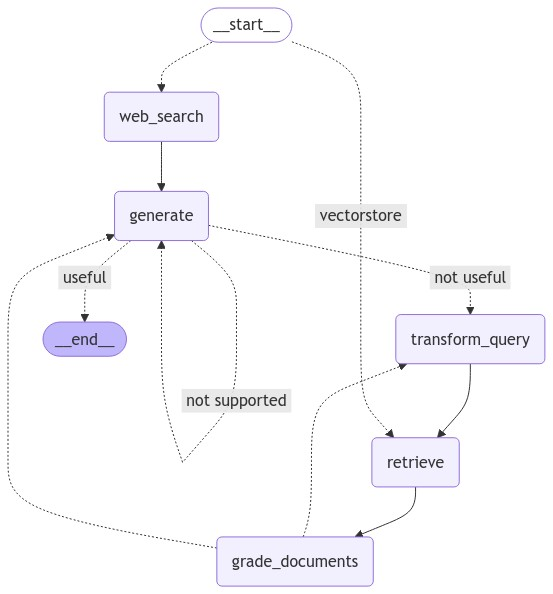

In [85]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

### 실행

In [81]:
from pprint import pprint

inputs = {
    "question": "베어스가 NFL 드래프트에서 첫 번째로 누구를 선발할 것인가?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # 노드
        pprint(f"노드 '{key}':")
        # 선택 사항: 각 노드에서 전체 상태 출력
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# 최종 생성
pprint(value["generation"])

---질문 라우팅---
---질문을 웹 검색으로 라우팅---
---웹 검색---
"노드 'web_search':"
'\n---\n'
---생성---
---환각 확인---
---결정: 생성된 답변이 문서에 근거함---
---생성된 답변 vs 질문 평가---
---결정: 생성된 답변이 질문을 해결함---
"노드 'generate':"
'\n---\n'
'시카고 베어스는 2023 NFL 드래프트 첫 라운드에서 테네시대 출신 라인맨 다넬 라이트를 지명했다.'


In [82]:
# Trace
inputs = {"question": "에이전트 메모리의 유형은 무엇인가요?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # 노드
        pprint(f"노드 '{key}':")
        # 선택 사항: 각 노드에서 전체 상태 출력
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# 최종 생성
pprint(value["generation"])

---질문 라우팅---
---질문을 RAG로 라우팅---
---검색---
"노드 'retrieve':"
'\n---\n'
---문서의 질문 관련성 확인---
---평가: 문서 관련 있음---
---평가: 문서 관련 있음---
---평가: 문서 관련 있음---
---평가: 문서 관련 있음---
---평가된 문서 검토---
---결정: 생성---
"노드 'grade_documents':"
'\n---\n'
---생성---
---환각 확인---
---결정: 생성된 답변이 문서에 근거함---
---생성된 답변 vs 질문 평가---
---결정: 생성된 답변이 질문을 해결함---
"노드 'generate':"
'\n---\n'
('에이전트 메모리의 유형은 감각 기억, 단기 기억(작업 기억), 그리고 장기 기억입니다. 감각 기억은 시각, 청각 등 감각 정보를 짧게 '
 '유지하며, 단기 기억은 현재 인지하고 있는 정보를 저장합니다. 장기 기억은 사실과 사건을 오랜 기간 동안 저장할 수 있습니다.')
